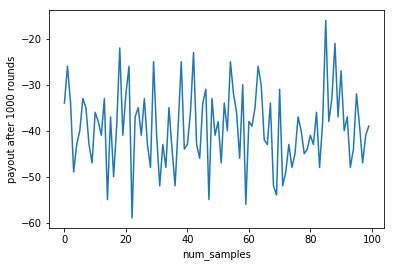

Average payout after 100 rounds is -39.19


In [90]:
import gym
import matplotlib.pyplot as plt

env = gym.make('Blackjack-v0')
env.seed(0)
env.reset()

num_rounds = 100 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

average_payouts = []

for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action 
#         print('ACTION: ' + str(action))
        
        obs, payout, is_done, info = env.step(action)
#         print('OBS: ' + str(obs))
#         print('PAYOUT: ' + str(payout))
#         print('ID_DONE: ' + str(is_done))
#         print('INFO: ' + str(info))

        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

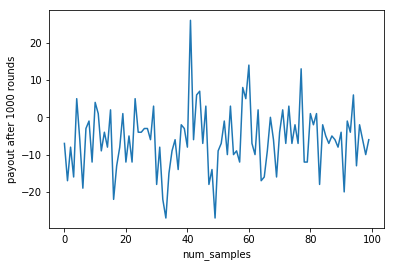

Average payout after 100 rounds is -5.94


In [91]:
def normal_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*10 # 2 to 11
    actions.append([1]*2 + [0]*3 + [1]*5) #12
    actions.extend([[0]*6 + [1]*4]*4) #13-16
    actions.extend([[0]*10]*5) #17-21
    
#     for x in actions:
#         print(x)
    
    # dealer_up_card-2 takes care of input 1 which correcly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

# Make sure actions have been stored correctly mainly when dealer's upcard is A
# assert (normal_strategy(15, 2)) == 0
# assert (normal_strategy(15, 1)) == 1


num_rounds = 100 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples
total_payout = 0 # to store total payout over 'num_rounds'

average_payouts = []

for x in range(num_samples):
    round = 1
    round_payout = 0
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done = (env._get_obs())
        
        # Take action based on normal strategy stored above
        action = normal_strategy(player_sum, dealer_up_card) 
#         print(player_sum)
#         print(dealer_up_card)
#         print(normal_strategy(player_sum, dealer_up_card))
        
        
        obs, payout, is_done, _ = env.step(action)
        round_payout += payout
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(round_payout)

    
plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()     
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/num_samples))


In [204]:
import random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
import pandas as pd

random.seed(0)

class DQNAgent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, time = 30000):
        self.env = env
        self.action_size = self.env.action_space.n
        self.state_size = env.observation_space
        self.memory = deque(maxlen=2000) # Record past experiences- [(state, action, reward, next_state, done)...]
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning = True
        self.model = self._build_model()
        
        self.time = time 
        self.time_left = time # Epsilon Decay
        self.small_decrement = (0.4 * epsilon) / (0.3 * self.time_left) # reduce epsilon
        print('HELLO')
    
    # Build Neural Net
    def _build_model(self):
        model = Sequential()
        model.add(Dense(20, input_shape =(2,), kernel_initializer='random_uniform', activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(self.action_size, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=self.alpha))
        
        return model
       
#     # Remember function that stores states, actions, rewards, and done to memory
#     def remember(self, state, action, reward, next_state, done):
#         self.memory.append([state, action, reward, next_state, done])

    def choose_action(self, state):
        """
        Choose which action to take, based on the observation. 
        Uses greedy epsilon for exploration/exploitation.
        """

        # if random number > epsilon, act 'rationally'. otherwise, choose random action
        
        if np.random.rand() <= self.epsilon:
#             print(np.random.rand())
#             print(self.epsilon)
#             print('random')
#             print('-------')
            
            action = random.randrange(self.action_size)
            print('random: ' + str(action))

            
        else:
#             print('logic')

            action_value = self.model.predict(state)
            print(action_value)
#             print(action_value)
#             print(action_value)
#             print('-------')
            action = np.argmax(action_value[0])
#             print(action)
        
        self.update_parameters()
        return action
        
    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
#         print(self.time_left)
        if self.time_left > 0.9 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.7 * self.time:
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.5 * self.time:
            self.epsilon -= self.small_decrement
#             print('0.5')
        elif self.time_left > 0.3 * self.time:
#             print('0.2')
            self.epsilon -= self.small_decrement
        elif self.time_left > 0.1 * self.time:
            self.epsilon -= self.small_decrement
#         elif self.time_left < 0.05 * self.time:
#             self.epsilon = 0.000
#             self.learning = False

#         print(self.time_left)
        #         print(self.time)
        self.time_left -= 1       


    def learn(self, state, action, reward, next_state, done):
        
        
        
#         minibatch = random.sample(self.memory, batch_size)
#         print(minibatch)
        
        target = reward
#         print('STATE: ' + str(state))
#             print('next_state: ' + str(state))

#         print('target: ' + str(target))

        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

#         print('target: ' + str(target))


#         print('action: ' + str(action))
#             print(self.model.predict(next_state))
#         print(np.amax(self.model.predict(next_state)[0]))

        target_f = self.model.predict(state)
#         print(target_f)
#         print('target_f: ' + str(target_f))


        target_f[0][action] = target
#         print('target_f: ' + str(target_f))
#             print('target_f: ' + str(target_f))
#         print('-------')

        self.model.fit(state, target_f, epochs=1, verbose=0)
        
        
#             print(self.time)
#         print(self.epsilon)

    def get_optimal_strategy(self):
        index = []
        for x in range(0,21):
            for y in range(1,11):
                index.append((x,y))

        df = pd.DataFrame(index = index, columns = ['Stand', 'Hit'])

        for ind in index:
            outcome = self.model.predict([np.array([ind])], batch_size=1)
            df.loc[ind, 'Stand'] = outcome[0][0]
            df.loc[ind, 'Hit'] = outcome[0][1]


        df['Optimal'] = df.apply(lambda x : 'Hit' if x['Hit'] >= x['Stand'] else 'Stand', axis=1)
        df.to_csv('optimal_policy.csv')
        return df


HELLO
random: 1
random: 1
random: 0
random: 1
random: 1
random: 1
random: 1
random: 1
random: 1
random: 0
random: 0
random: 1
random: 0
random: 0
random: 1
random: 0
random: 1
random: 0
random: 0
random: 1
random: 1
random: 0
random: 1
random: 1
random: 1
random: 0
random: 1
random: 1
random: 1
random: 0
random: 0
random: 0
random: 1
random: 0
random: 1
random: 1
random: 0
random: 1
random: 0
random: 0
random: 0
random: 0
random: 0
random: 1
random: 0
random: 0
random: 1
random: 1
random: 0
random: 1
random: 1
random: 0
random: 1
random: 0
random: 1
[[ 0.37556872  0.19594604]]
random: 1
random: 0
random: 1
random: 1
random: 0
random: 1
random: 0
[[ 0.30180129  0.09095106]]
random: 0
random: 0
random: 0
random: 1
random: 1
[[ 0.30623591  0.09862686]]
random: 0
random: 0
random: 0
random: 0
random: 0
random: 0
random: 1
random: 1
random: 0
random: 0
random: 1
random: 1
random: 1
random: 1
random: 1
random: 0
random: 1
random: 0
random: 1
random: 1
random: 0
random: 0
random: 0
random: 1


[[  1.69724857e-12   5.65044429e-17]]
random: 1
[[  6.80149513e-12   1.77016889e-16]]
random: 0
[[  8.19434798e-12   6.38024232e-16]]
[[  2.29680813e-06   4.47833637e-09]]
random: 0
[[  1.45644080e-05   1.88274086e-07]]
[[  2.77903882e-06   5.80913451e-08]]
[[  1.48858916e-08   8.94612856e-12]]
random: 0
random: 0
[[  1.50380870e-07   3.37921802e-10]]
[[  9.49941210e-08   8.12418119e-11]]
[[  2.36829978e-09   5.17138144e-13]]
[[  1.29382613e-07   1.14352805e-09]]
random: 1
random: 1
random: 0
[[  1.07076952e-13   4.62698075e-18]]
random: 0
random: 1
[[  3.30819955e-10   8.63277277e-14]]
[[  2.38783741e-07   6.16317886e-10]]
random: 1
random: 0
[[  1.72715249e-12   1.22719430e-16]]
[[  2.62955635e-09   1.50822098e-11]]
random: 1
random: 0
[[  1.09836396e-09   8.12818725e-13]]
random: 0
[[  2.70792208e-11   4.17441469e-15]]
random: 1
random: 1
[[  1.87642585e-13   2.74836003e-17]]
[[  1.80911425e-13   2.68588258e-17]]
[[  6.32338420e-13   8.94276210e-17]]
[[  1.34121638e-08   3.46845642e

[[  2.19782281e-09   5.91396862e-11]]
[[  1.52831719e-12   4.33262502e-14]]
[[  1.81630516e-10   2.84901638e-12]]
random: 0
[[  5.00319333e-16   5.85507927e-18]]
random: 0
random: 0
[[  5.98336027e-15   1.01021371e-16]]
[[  8.17938043e-14   1.89674013e-15]]
random: 1
random: 0
[[  4.49669039e-15   8.44300207e-17]]
random: 1
[[  6.83938284e-18   3.86079572e-20]]
[[  7.05536093e-17   8.29692191e-19]]
[[  2.63578894e-12   2.24838814e-14]]
[[  6.56210790e-14   1.41545929e-15]]
[[  1.06871685e-13   1.20821510e-15]]
random: 0
[[  1.24542060e-18   7.52554785e-21]]
[[  1.27308456e-13   7.03534555e-15]]
[[  1.81363672e-13   9.72618499e-16]]
[[  2.34286323e-11   4.72674634e-13]]
[[  2.49265435e-17   1.32041781e-19]]
[[  3.39346769e-13   5.15888423e-15]]
[[  2.99429300e-19   1.49459642e-21]]
[[  1.16084036e-13   6.63412764e-15]]
[[  1.42137550e-12   2.24087445e-14]]
[[  2.86634445e-19   1.45480370e-21]]
[[  1.34468378e-13   6.23625297e-15]]
[[  4.87729082e-17   6.58861662e-19]]
random: 0
[[  6.33

[[  1.11849690e-12   3.43492799e-14]]
random: 1
[[  2.46634210e-16   2.67343078e-18]]
[[  2.55366373e-14   1.96249614e-15]]
[[  2.35377490e-18   2.69240262e-20]]
[[  7.63717431e-15   3.82312371e-16]]
[[  4.24336339e-19   6.10342485e-21]]
[[  9.80666381e-11   2.64910628e-11]]
[[  3.10673167e-12   1.86254807e-13]]
[[  1.93293546e-20   2.83529231e-22]]
[[  1.93277326e-20   2.83514085e-22]]
[[  1.37657582e-15   8.66577041e-17]]
[[  1.92889646e-15   7.83245609e-17]]
[[  3.37018413e-08   1.35753364e-08]]
[[  2.93802960e-16   1.86775960e-17]]
[[  5.76890794e-16   1.52586368e-17]]
[[  4.88210197e-21   5.80879116e-23]]
[[  5.01041774e-14   1.60254335e-15]]
[[  5.61021354e-18   1.52802903e-19]]
[[  1.77019354e-11   5.98950143e-12]]
[[  1.93185932e-20   2.83434063e-22]]
[[  9.01795416e-10   1.00383986e-10]]
[[  4.85518558e-06   1.22513620e-06]]
[[  8.28266453e-18   1.22323366e-19]]
[[  1.13403753e-18   2.73984546e-20]]
[[  1.14854610e-14   2.65018107e-16]]
[[  1.16809750e-15   6.75576009e-17]]
[[

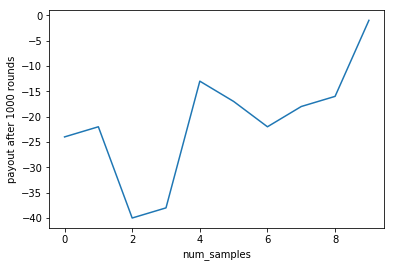

Average payout after 100 rounds is -21.1


In [205]:
import gym
env = gym.make('Blackjack-v0')
env.seed(0)
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt
from collections import deque
import time

start_time = time.time()

# print(agent.model)

num_rounds = 100 # Payout calculated over num_rounds
num_samples = 10 # num_rounds simulated over num_samples

agent = DQNAgent(env=env, epsilon=1.0, alpha=0.001, gamma=0.1, time=1500)

average_payouts = []

state = env.reset()
state = np.reshape(state[0:2], [1,2])
for sample in range(num_samples):
    round = 1
    total_payout = 0 # store total payout per sample
    while round <= num_rounds:
        action = agent.choose_action(state)
        next_state, payout, done, _ = env.step(action)
        next_state = np.reshape(next_state[0:2], [1,2])

        
        total_payout += payout    
#         if agent.learning:
        agent.learn(state, action, payout, next_state, done)
        
        state = next_state
        state = np.reshape(state[0:2], [1,2])
        
        if done:
            state = env.reset() # Environment deals new cards to player and dealer
            state = np.reshape(state[0:2], [1,2])
            round += 1

    average_payouts.append(total_payout)

    if sample % 10 == 0:
        print('Done with sample: ' + str(sample) + str("   --- %s seconds ---" % (time.time() - start_time)))
        print(agent.epsilon)

print(agent.get_optimal_strategy())

# Plot payout per 1000 episodes for each value of 'sample'

plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))